# Single-Cell RNA Seq Example

## Outline

- [Setup](#setup)
- [Overview: Adjusting for observed confounding](#overview:-adjusting-for-observed-confounding)
- [Example: Understanding the mechanism of action of a drug using causal inference](#example:-example:-understanding-the-mechanism-of-action-of-a-drug-using-causal-inference)
- [Causal Probabilistic Program](#causal-probabilistic-program)





## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import torch
from typing import List

pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

sns.set_style("white")

## Overview: Adjusting for observed confounding

### **Task:** Treatment effect estimation with observational data
In this example, we are interested in estimating how changes (or interventions) to a particular treatment variable $T$ influence a particular outcome variable $Y$. We wish to estimate this causal effect using *observational* (non-randomized) data from $T$, $Y$, and some collection of covariates $X = \{X_1, ..., X_d\}$. 

## Example: Understanding the mechanism of action of a drug using causal inference

### Source

We analyze the SciPlex3 dataset from [3], which consists of over 650K single-cell measurements (`X`) for three different cancer cell types (`cell_type`): MCF7, K562, and A549. Each cell in this dataset is unperturbed (`Vehicle`) or randomly treated with a drug from a library of 188 drug perburbations (`product_name`) at 4 different dosages (`dose`): $10^1, 10^2, 10^3, 10^4$ nM.

In [2]:
# Download raw data if doesn't already exist

if not os.path.exists("SrivatsanTrapnell2020_sciplex3_debugged.h5"):
    # Download and unzip 3 files files from here:
    # https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4150378
    # (1) GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz
    # (2) GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz
    # (3) GSM4150378_sciPlex3_pData.txt.gz

    # Cach raw zip files
    os.system(
        "wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz"
    )
    os.system(
        "wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz"
    )

    os.system(
        "wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_pData.txt.gz"
    )

    # unzip files
    os.system("gunzip GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz")
    os.system("gunzip GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz")
    os.system("gunzip GSM4150378_sciPlex3_pData.txt.gz")
    
    # Run processing script to save as h5 file
    os.system("python ShrivasanTrapnell2020.py") # outputs files as SrivatsanTrapnell2020_sciplex3_debugged.h5

We preprocess the data as follows:
- Filter out cells that have unknown cell type
- Only include measurements at the 24hr timepoint (retains ~90% of the dataset)
- Restrict to human genes since all cells are from human cell lines
- Filter out genes that are expressed in fewer than 10 cells
- Filter out cells that have fewer than 200 expressed genes

In [3]:
# Load in sciplex3 study data as anndata
anndata = sc.read_h5ad("SrivatsanTrapnell2020_sciplex3_debugged.h5")

# Remove unknown cell types
anndata = anndata[~anndata.obs['cell_type'].isnull()]

# Filter out to only 24hr observations (~90% of the data remains)
anndata = anndata[anndata.obs['time_point'] == 24]

# Restrict to genes in human genome
annot = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "hgnc_symbol"]
)
annot = annot.dropna()
anndata = anndata[:, anndata.var['ensembl_gene_id'].isin(annot['ensembl_gene_id'].values)]

temp = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "hgnc_symbol", "description"]
)

# Filter out genes that are expressed in less than 10 cells
sc.pp.filter_genes(anndata, min_cells=10)

# Filter out cells that express less than 200 genes
sc.pp.filter_cells(anndata, min_genes=200)

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/annd

### Goal: Understand the mechanism of action for the cancer drug candidate Panobinostat LBH589

We analyze a particular drug (Panobinostat LBH589), which is currently in a Phase III clinical trial for treating acute myeloid leukaemia. We start our analysis by looking at several summary statistics and visualizations of this drug. Then, we use `ChiRho` to estimate the causal effect of this drug on gene expression levels.



In [4]:
drug_target = 'Panobinostat (LBH589)'

# Set of pathway target of the drug
anndata.obs[anndata.obs.product_name == drug_target][['target']].drop_duplicates().reset_index(drop=True)

,target
0,HDAC


Histone deacetylase (HDAC) inhibitors are anti-cancer agents that can induce death, apoptosis, and cell cycle arrest in cancer cells [2]. As shown above, Panobinostat LBH589 targets the HDAC pathway, which consists of 18 genes (`hdac_genes`) [4]. We focus on modeling the changes in  expression of these 18 genes in response to Panobinostat LBH589. 

In [6]:
# Different subgroups part of the histone deacetylase family from [4]
sirt = ["SIRT1", "SIRT2", "SIRT3", "SIRT4", "SIRT5", "SIRT6", "SIRT7"]
class_one = ["HDAC1", "HDAC2", "HDAC3", "HDAC8"]
class_two_a = ["HDAC4", "HDAC5", "HDAC7", "HDAC9"]
class_two_b = ["HDAC6", "HDAC10"]
class_four = ["HDAC11"]

hdac_genes = sirt + class_one + class_two_a + class_two_b + class_four
hdac_data = anndata[:, anndata.var.index.isin(hdac_genes)]
hdac_data = hdac_data[hdac_data.obs['product_name'].isin([drug_target, 'Vehicle'])]

Let's look at how each of these genes are expressed in the dataset. We plot the distribution of log expression levels for each gene, stratified by cell type and log treatment dosages. We see that the expression levels of these genes vary across cell types, and that treatment with Panobinostat LBH589 induces changes in expression levels for some genes but not others.

/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_54175/1371780715.py:2: RuntimeWarning: divide by zero encountered in log10
  drug_expression_df['log10_dose'] = np.log10(hdac_data.obs['dose'].values)


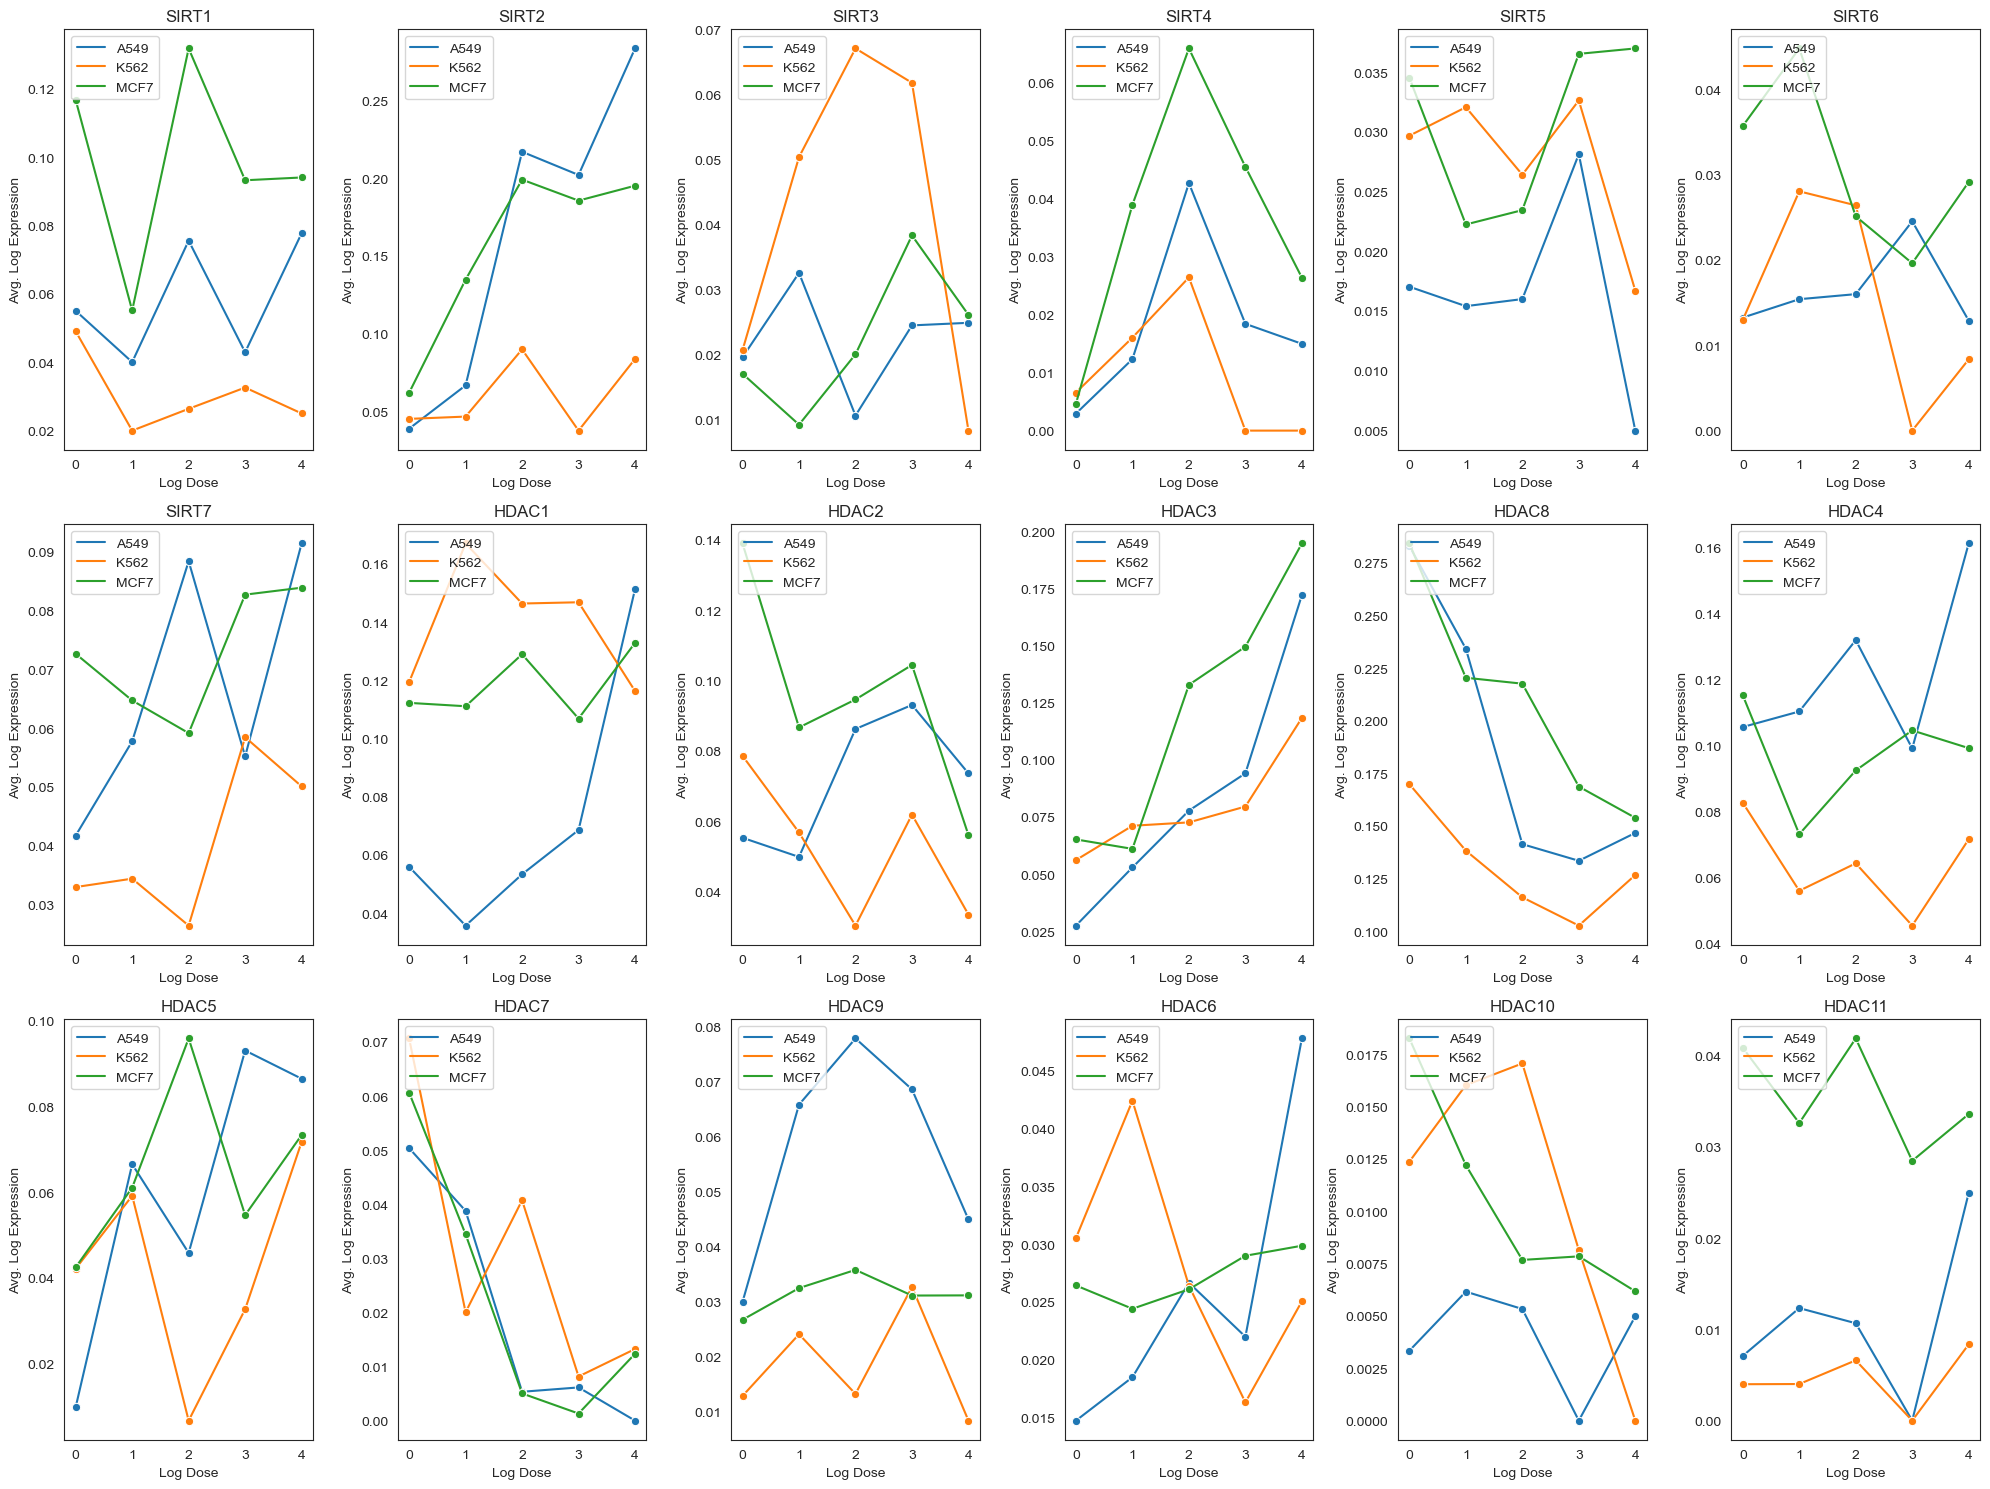

In [80]:
drug_expression_df = pd.DataFrame(hdac_data.X.toarray(), columns=hdac_data.var.index)
drug_expression_df['log10_dose'] = np.log10(hdac_data.obs['dose'].values)
drug_expression_df = drug_expression_df.replace(-np.inf, 0)
drug_expression_df['cell_type'] = hdac_data.obs['cell_type'].values
avg_log_expression = drug_expression_df.groupby(by=['cell_type', 'log10_dose']).apply(lambda x: np.log(x + 1).mean()).reset_index()
avg_log_expression = avg_log_expression.melt(id_vars=['cell_type', 'log10_dose'])
avg_log_expression.rename({'value': 'avg_log_expression'}, inplace=True, axis=1)

# Plot each of the 18 genes 
fig, ax = plt.subplots(3, 6, figsize=(20, 15))

for i, gene in enumerate(hdac_genes):
    curr_ax = ax[i // 6][i % 6]
    sns.lineplot(data=avg_log_expression[avg_log_expression.gene_name == gene], x='log10_dose', y='avg_log_expression', hue='cell_type', ax=curr_ax, marker='o')
    curr_ax.set_title(gene)
    curr_ax.set_xlabel('Log Dose')
    curr_ax.set_ylabel('Avg. Log Expression')
    curr_ax.legend(loc='upper left')

plt.tight_layout()    

Panobinostat LBH589 is biologically known to be an inhibitor of genes in the HDAC pathway. So we would expect that dosage is negatively correlated with expression levels. However, the plots above suggest that Panobinostat LBH589 sometimes increases expression levels for certain cell types. For example, in the HDAC1 gene and A549 cell type, Panobinostat LBH589 leads to an increase (on average). Could this positive correlation be due to uncontrolled confounding?

## Causal Probabilistic Program

### Model Description
In the plots above, we did not control for technical covariates (e.g., such as which plate the cell was place in, replicate number, etc.), nor did we leverage the dependence structure in the data. We also made the response binary (expresses gene or not) instead of leveraging the actual expression magnitudes. TODO: describe model.

In [104]:
class DrugPerturbationCATEModel(PyroModule):
    def __init__(self, num_genes: int, num_confounders: int):
        super().__init__()
        self.num_genes = num_genes
        self.num_confounders = num_confounders

    def forward(self, X: torch.tensor, T: torch.tensor, Y: torch.tensor):
        assert X.shape[1] == self.num_confounders
        assert Y.shape[1] == self.num_genes
        assert T.shape[0] == X.shape[0]
        T = T.reshape(-1, 1) # Broadcast treatment vector
        with pyro.plate("genes", self.num_genes):
            # Sample parameters
            intercept = pyro.sample("intercept", dist.Normal(0, 1).expand((self.num_genes, 1)).to_event(1))
            theta_X = pyro.sample("theta_X", dist.Normal(0, 1).expand((self.num_genes, self.num_confounders)).to_event(1)) # G x F
            theta_T = pyro.sample("theta_T", dist.Normal(0, 1).expand((self.num_genes, 1)).to_event(1))
            theta_X_T = pyro.sample("theta_X_T", dist.Normal(0, 1).expand((self.num_genes, self.num_confounders)).to_event(1)) # G x F
            # TODO: maybe make this a function of technical covariates
            dropout_logits = pyro.sample("dropout_logits", dist.Normal(0, 1).expand((self.num_genes, 1)).to_event(1))
            with pyro.plate("samples", X.shape[0]):
                    confounder_variation = intercept.squeeze() + torch.matmul(X, theta_X.T) # N x G
                    treatment_variation = theta_T.squeeze() + torch.matmul(X * T, theta_X_T.T) # N x G
                    mean = confounder_variation + treatment_variation # N x G
                    dropout_logits = dropout_logits.squeeze().expand((X.shape[0], self.num_genes)) # N x G
                    pyro.sample("Y_gene", dist.ZeroInflatedPoisson(rate=torch.exp(mean), gate_logits=dropout_logits), obs=Y)


def run_svi_inference(model, n_steps=1000, verbose=True, lr=0.03, **model_kwargs):
    guide = AutoNormal(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 250 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [103]:
# Make data matrices
X_confounders = pd.get_dummies(hdac_data.obs[['cell_type', 'replicate', 'culture_plate', 'pcr_plate', 'well_oligo']], dtype=np.int32).reset_index(drop=True)

# Control for sequencing depth
log_umi = np.log10(hdac_data.obs['n.umi'].values)
scaled_log_umi = (log_umi - np.mean(log_umi)) / log_umi.std()
X_confounders['depth_proxy'] = scaled_log_umi

# For each drug, input log dose as a feature
T_all = pd.get_dummies(hdac_data.obs[['product_name']], dtype=np.int32).reset_index(drop=True)
T_all = T_all.mul(np.log10(hdac_data.obs['dose'].values + 1), axis=0)

# Get response for all gene expressions in HDAC pathway
Y_hdac = torch.tensor(hdac_data.X.toarray(), dtype=torch.float32)

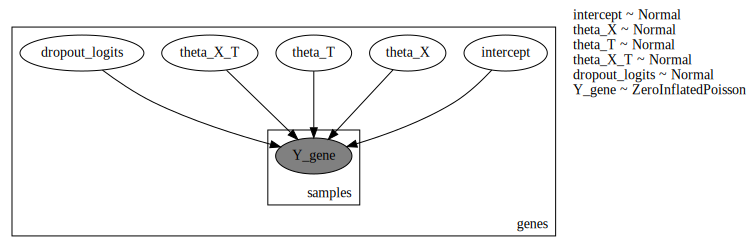

In [105]:
# Render model
model = DrugPerturbationCATEModel(num_genes=Y_hdac.shape[1], num_confounders=X_confounders.shape[1])

# Visualize model
pyro.render_model(
    model, 
    model_args=(
        torch.tensor(X_confounders.values, dtype=torch.float32), 
        torch.tensor(T_all['product_name_Vehicle'].values, dtype=torch.float32), 
        Y_hdac
    ), 
    render_params=True, 
    render_distributions=True
)

### Causal Query: average treatment effect (ATE)

TODO: add description

In [106]:
# We use our model to understand the conditional average treatment effect (ATE) of Panobinostat (LBH589), which is 
# a cancer drug that is in a Phase III clinical trial for acute myeloid leukaemia
drug_target = 'Panobinostat (LBH589)'
drug_control_mask = torch.tensor(hdac_data.obs['product_name'].isin(['Vehicle', drug_target]).values)
T_drug_control = torch.tensor(T_all[f'product_name_{drug_target}'].values, dtype=torch.float32)[drug_control_mask]
X_drug_control = torch.tensor(X_confounders.values[drug_control_mask], dtype=torch.float32)
Y_drug_control = Y_hdac[drug_control_mask]

# Split into training and test set
N_drug_control = X_drug_control.shape[0]
train_mask = torch.tensor(np.random.choice([True, False], size=N_drug_control, p=[0.8, 0.2]))
X_train = X_drug_control[train_mask]
T_train = T_drug_control[train_mask]
Y_train = Y_drug_control[train_mask]
X_test = X_drug_control[~train_mask]
T_test = T_drug_control[~train_mask]
Y_test = Y_drug_control[~train_mask]

In [107]:
# Fit model 
model = DrugPerturbationCATEModel(num_genes=Y_hdac.shape[1], num_confounders=X_confounders.shape[1])
guide = run_svi_inference(model, n_steps=1000, verbose=True, X=X_train, T=T_train, Y=Y_train)

[iteration 0001] loss: 138419.5625
[iteration 0250] loss: 74600.6797
[iteration 0500] loss: 74303.7656
[iteration 0750] loss: 74285.5000
[iteration 1000] loss: 74288.5469


In [108]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=500)
predictive_samples = predictive(X_test, T_test, Y_test)

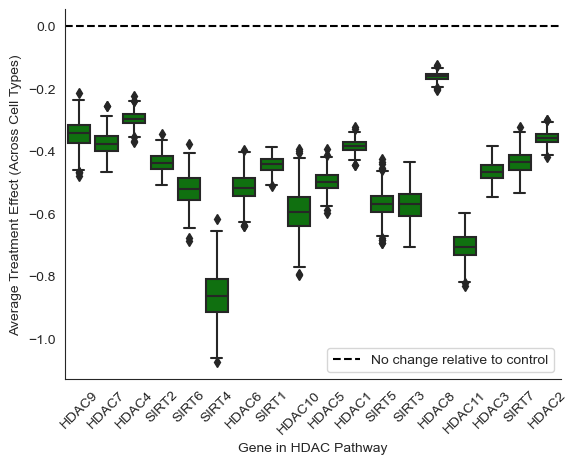

In [109]:
avg_treat_effects_by_gene = pd.DataFrame(predictive_samples['theta_T'].squeeze(), columns=hdac_data.var.index)

sns.boxplot(data=avg_treat_effects_by_gene, color='green')
plt.axhline(0, color='black', linestyle='--', label='No change relative to control')
plt.xlabel('Gene in HDAC Pathway')
plt.xticks(rotation=45)
plt.ylabel('Average Treatment Effect (Across Cell Types)')
plt.legend()
sns.despine()

### Causal Query: conditional average treatment effect (CATE)

TODO: add description

# References

1. https://www.science.org/doi/10.1126/science.aax6234
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3056563/#:~:text=Histone%20deacetylase%20(HDAC)%20inhibitors%20are,cycle%20arrest%20in%20cancer%20cells.
3. https://www.frontiersin.org/articles/10.3389/fcell.2020.576946/full
4. https://www.genenames.org/data/genegroup/#!/group/937